# Membuat Classifier nya

In [1]:
    # !pip install tensorflow
# !pip install pillow

In [2]:
import tensorflow as tf

In [3]:
# Define Input Parameters
dim = (224, 224)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

# Membuat dataset generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mendefinisikan Data Generatornya

In [5]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen   = ImageDataGenerator(rescale=1. / 255)
test_datagen  = ImageDataGenerator(rescale=1. / 255)

## Mendefinisikan asal folder sumber file berasal

In [6]:
# binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('cabe_final/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('cabe_final/valid/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory( 'cabe_final/test/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False  # Jangan acak urutan test data
                                                )

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 1200 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [7]:
print(labels)

dict_keys(['Keriting', 'Kuning', 'Layu'])


## Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

In [8]:
import tensorflow as tf

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    # Mendefinisikan output_signature
    output_signature = (
        tf.TensorSpec(shape=(None, input_shape[0], input_shape[1], input_shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_class), dtype=tf.float32)
    )
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    return tf_generator

In [9]:
# Menginisialisasi data generator
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

# Using CNN

In [10]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# # === Model CNN Sederhana ===
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.25),  # Regularisasi untuk mengurangi overfitting
#     Dense(3, activation='softmax')  # 3 kelas (ganti sesuai jumlah kelas Anda)
# ])

# # === Compile Model ===
# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# === Model CNN dengan Regularisasi ===
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),  # L2 Regularization pada Conv2D
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout setelah pooling untuk mengurangi overfitting
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # L2 Regularization pada Conv2D
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout setelah pooling untuk mengurangi overfitting
    
    # Block 3
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # L2 Regularization pada Conv2D
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout setelah pooling untuk mengurangi overfitting
    
    # Fully Connected Layer
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 Regularization pada Dense layer
    Dropout(0.25),  # Dropout pada layer Fully Connected untuk mencegah overfitting
    
    # Output Layer
    Dense(3, activation='softmax')  # 3 kelas (ganti sesuai jumlah kelas Anda)
])

# === Compile Model ===
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Menampilkan summary model
model.summary()


D:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.optimizers import Adam
# === Compile Model ===
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Visualize The final model

In [12]:
# import tensorflow as tf

In [13]:
# model_viz = tf.keras.utils.plot_model(model,
#                           to_file='model.png',
#                           show_shapes=True,
#                           show_layer_names=True,
#                           rankdir='TB',
#                           expand_nested=True,
#                           dpi=55)
# model_viz

# Train Model

In [14]:
EPOCH = 10

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Menentukan callback untuk early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memonitor validasi loss
    patience=3,          # Berhenti jika tidak ada perbaikan setelah 5 epoch
    restore_best_weights=True  # Mengembalikan bobot terbaik
)

# # (Opsional) Menyimpan model terbaik selama pelatihan
# model_checkpoint = ModelCheckpoint(
#     'best_model.h5',    # Nama file model terbaik
#     monitor='val_loss', # Memonitor validasi loss
#     save_best_only=True # Hanya menyimpan model terbaik
# )

# Training model dengan callback
history = model.fit(
    x=train_data,
    steps_per_epoch=len(train_generator),  # Total step per epoch
    epochs=EPOCH,
    validation_data=val_data,
    validation_steps=len(val_generator),  # Total step validasi
    shuffle=True, 
    verbose=1,
    callbacks=[early_stopping]  # Memasukkan callbacks
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 585ms/step - accuracy: 0.3790 - loss: 1.6028 - val_accuracy: 0.6600 - val_loss: 1.3152
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 573ms/step - accuracy: 0.6736 - loss: 1.0398 - val_accuracy: 0.8200 - val_loss: 0.7662
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 575ms/step - accuracy: 0.8346 - loss: 0.6637 - val_accuracy: 0.8800 - val_loss: 0.6030
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 598ms/step - accuracy: 0.8847 - loss: 0.5225 - val_accuracy: 0.9600 - val_loss: 0.4958
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 595ms/step - accuracy: 0.9442 - loss: 0.4224 - val_accuracy: 0.9800 - val_loss: 0.4063
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 766ms/step - accuracy: 0.9298 - loss: 0.4011 - val_accuracy: 0.9800 - val_loss: 0.3420
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9505 - loss: 0.3522 - val_accuracy: 0.9800 - val_loss: 0.3599
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 945ms/step - accuracy: 0.9530 - loss: 0.3470 - val_accurac

In [16]:
history.history['loss']

[1.4454187154769897,
 0.8972317576408386,
 0.6215423345565796,
 0.5084032416343689,
 0.4256535470485687,
 0.4011968672275543,
 0.36519816517829895,
 0.32730942964553833,
 0.3260807394981384,
 0.28753283619880676]

In [17]:
history.history['accuracy']

[0.45249998569488525,
 0.7350000143051147,
 0.8600000143051147,
 0.8949999809265137,
 0.9291666746139526,
 0.9366666674613953,
 0.9416666626930237,
 0.9624999761581421,
 0.9541666507720947,
 0.9691666960716248]

# Model Evaluation

In [18]:
loss, acc = model.evaluate(train_data, steps=len(train_generator), verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data, steps=len(test_generator), verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 0.9633 
Loss on training data: 0.3102 

Accuracy on test data: 1.0000 
Loss on test data: 0.2508 



In [19]:
# Evaluasi pada data validasi
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

# Evaluasi pada data uji
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


D:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9691 - loss: 0.2688
Validation Accuracy: 0.9800
Validation Loss: 0.2623
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 1.0000 - loss: 0.2368
Test Accuracy: 1.0000
Test Loss: 0.2508


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step


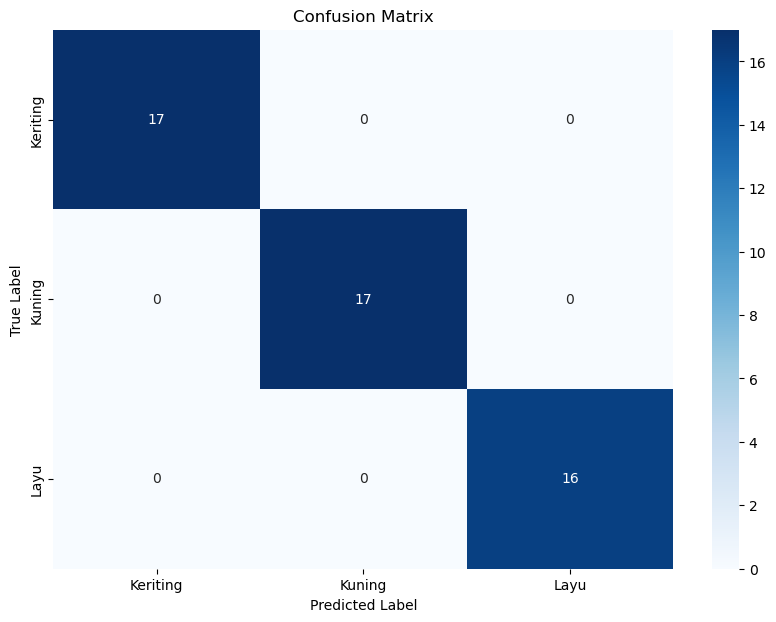

              precision    recall  f1-score   support

    Keriting       1.00      1.00      1.00        17
      Kuning       1.00      1.00      1.00        17
        Layu       1.00      1.00      1.00        16

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Akurasi model pada data uji: 100.00%


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Prediksi pada data uji
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Validasi jumlah label
y_true = test_generator.classes[:len(y_pred_classes)]  # Sinkronisasi jumlah sampel

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Menghitung akurasi
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Akurasi model pada data uji: {accuracy * 100:.2f}%")

# Identifikasi prediksi yang salah
misclassified_indices = np.where(y_true != y_pred_classes)[0]

# Menampilkan gambar yang diprediksi salah beserta label yang benar dan yang diprediksi
for idx in misclassified_indices:
    # Ambil nama gambar dari generator
    img_path = test_generator.filepaths[idx]  # Nama file gambar dari test_generator
    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred_classes[idx]]
    
    # Muat dan tampilkan gambar
    img = image.load_img(img_path, target_size=(224, 224))  # Sesuaikan ukuran jika diperlukan
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [21]:
# Periksa jumlah sampel uji
print(f"Jumlah sampel uji dalam generator: {test_generator.samples}")

# Periksa jumlah prediksi
print(f"Jumlah prediksi: {len(y_pred)}")

# Periksa apakah jumlahnya sama
if len(y_pred) == test_generator.samples:
    print("Jumlah sampel uji dan prediksi SAMA.")
else:
    print("Jumlah sampel uji dan prediksi TIDAK SAMA.")


Jumlah sampel uji dalam generator: 50
Jumlah prediksi: 50
Jumlah sampel uji dan prediksi SAMA.


C:\Users\VERI MARPAUNG\AppData\Local\Temp\ipykernel_4156\2354461567.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


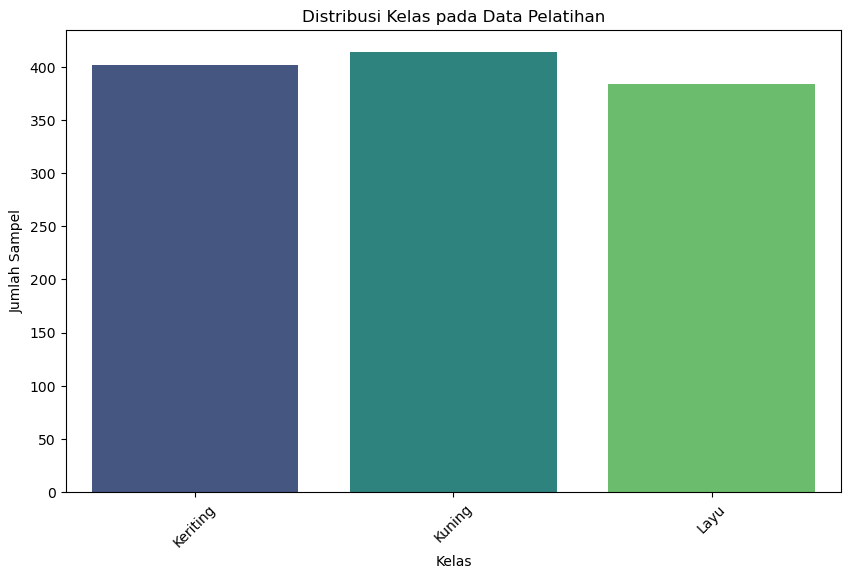

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mengambil label kelas dari train_generator
class_labels = train_generator.classes
# Menghitung jumlah data pada setiap kelas
class_counts = pd.Series(class_labels).value_counts()

# Membuat plot distribusi kelas
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribusi Kelas pada Data Pelatihan')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(ticks=range(len(class_counts)), labels=train_generator.class_indices.keys(), rotation=45)
plt.show()


# Plot the training

In [23]:
from matplotlib import pyplot as plt

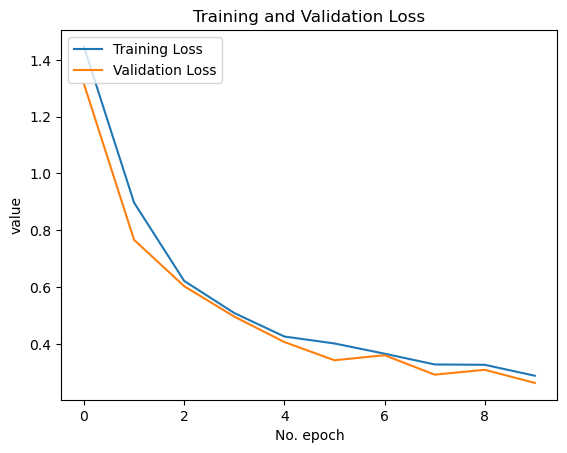

In [24]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

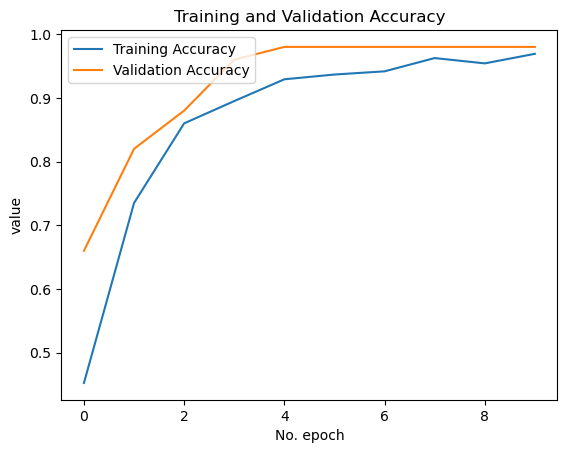

In [25]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Save Model

In [26]:
import os
import tensorflow as tf

MODEL_BASE_PATH = "model"
SAVE_MODEL_NAME = "CNN_train_v1.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, SAVE_MODEL_NAME)

# Cek dan buat folder jika belum ada
if not os.path.exists(os.path.join(MODEL_BASE_PATH)):
    os.makedirs(os.path.join(MODEL_BASE_PATH))
    
# Menyimpan model dalam format .h5
print('Saving Model in .h5 format at {}...'.format(save_model_path))
model.save(save_model_path, include_optimizer=False)    


Saving Model in .h5 format at model\CNN_train_v1.h5...


In [6]:
from tensorflow.keras.models import load_model

model = load_model('model/CNN_train_v1.h5')  # Ganti dengan path model kamu
